## Capitulo II

### Projeto de Machine Learning de Ponta a Ponta

---

### Importando as Libs

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
import urllib
from zlib import crc32
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.image as mpimg

### Declarando Variáveis

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

### Salvando Imagens Plotadas

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Download Dataset

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_h = fetch_housing_data()

### Carregando Dataset

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()

### Explorando Base de Dados

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Plotando os dados do Dataset

Saving figure attribute_histogram_plots


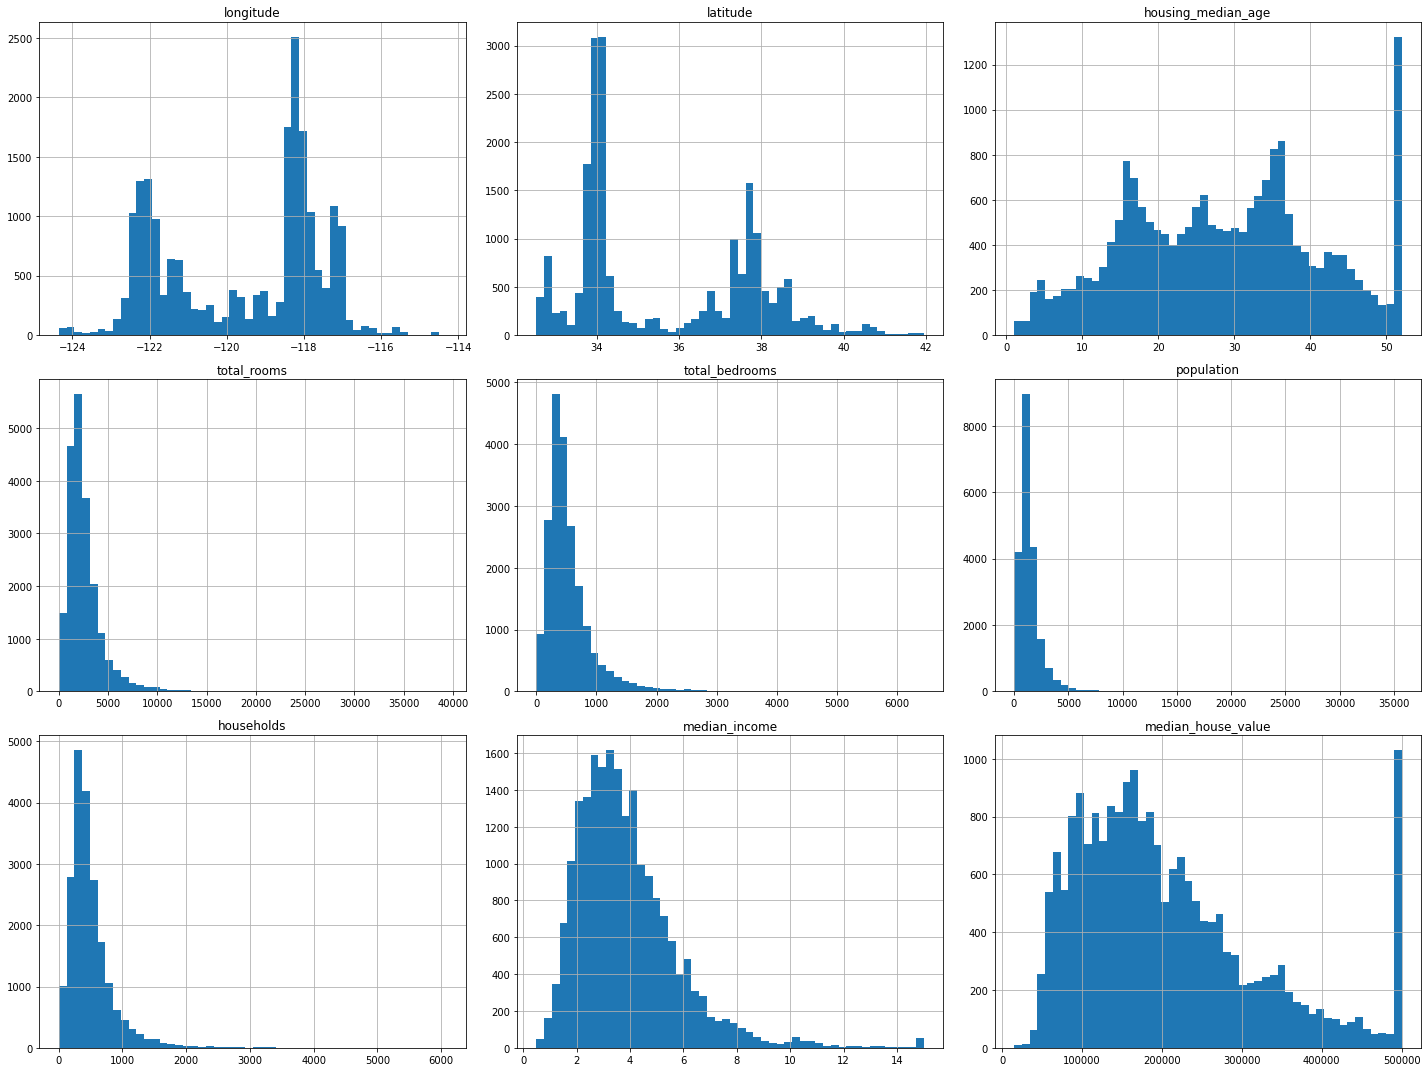

In [11]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### Criando um conjuto de Testes

In [12]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)

In [14]:
len(train_set)

16512

In [15]:
len(test_set)

4128

In [16]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [17]:
housing_with_id = housing.reset_index()     # Adicionando Index na Coluna
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [18]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [19]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

###  Histograma das categorias de renda

<AxesSubplot:>

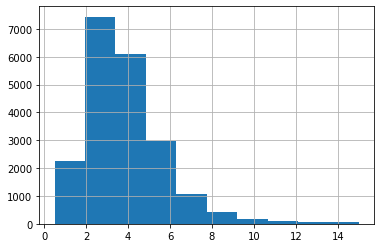

In [20]:
housing["median_income"].hist()

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2 , 3, 4, 5])

In [22]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

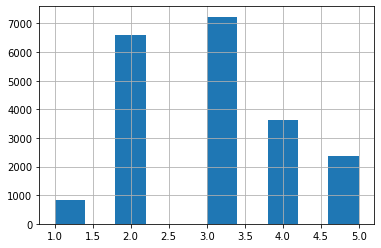

In [23]:
housing["income_cat"].hist()

In [24]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

### Comparação com viés de Amostragem Estratificada vs Amostragem Aleatória

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Descobrindo e Visualizando os dados para obter Insights

In [29]:
housing = strat_train_set.copy()

### Visualização Geográfica dos Dados

Saving figure bad_visualization_plot


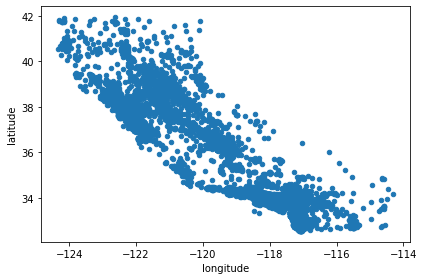

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


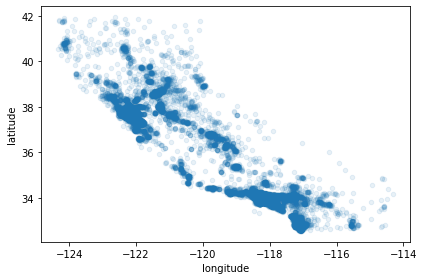

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

### Plotando Média de Preços de Moradias

Saving figure california_housing_prices_plot


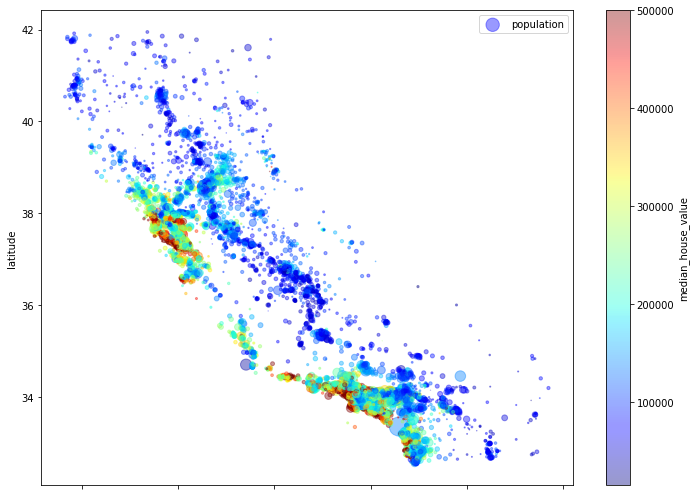

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
save_fig("california_housing_prices_plot")
plt.legend()

### Download Imagem da California

In [33]:
images_path = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/california.png', <http.client.HTTPMessage at 0x7f808834b850>)

Saving figure california_housing_prices_plot


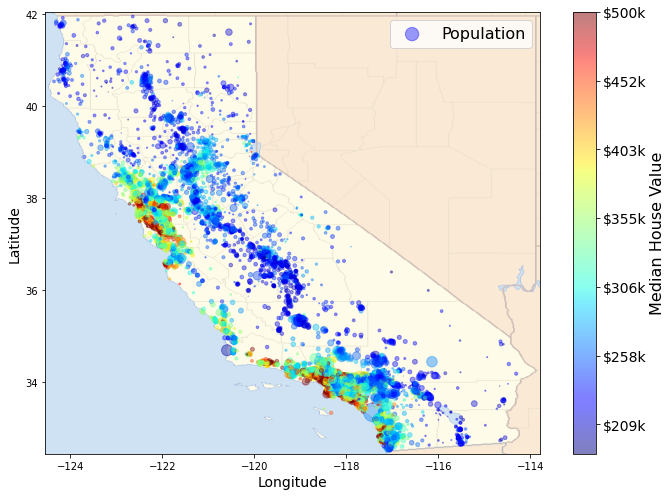

In [34]:
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Buscando Correlações

In [35]:
corr_matrix = housing.corr()

In [36]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


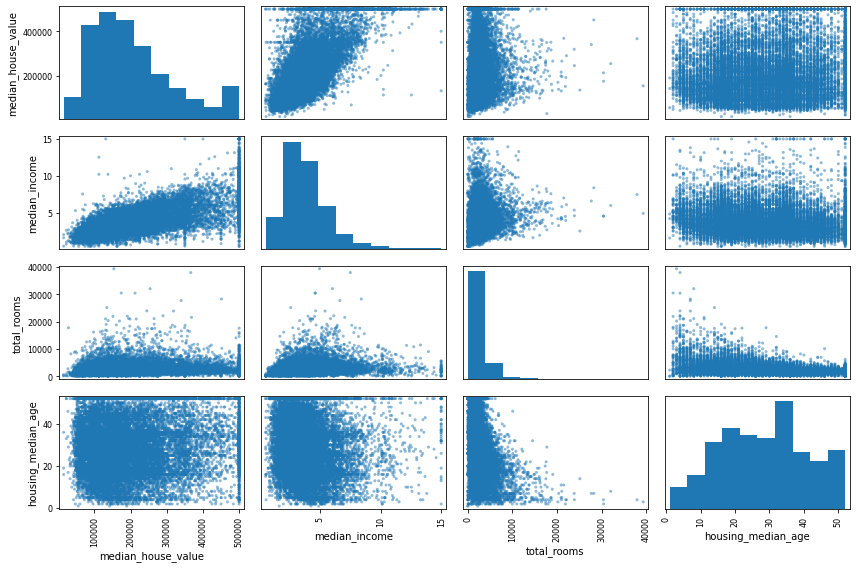

In [37]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


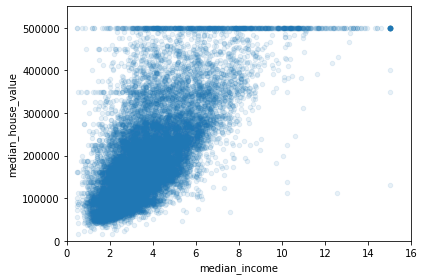

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

### Testando Combinações de Atributo

In [39]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [40]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

### Preparando os Dados para Aplicar ML

In [41]:
housing = strat_train_set.drop("median_house_value", axis=True)
housing_labels = strat_train_set["median_house_value"].copy()

### Limpando os Dados

In [42]:
#housing.dropna(subset=["total_bedrooms"])      # Opção 1
#housing.drop("total_bedrooms", axis=1)         # Opção 2
median = housing["total_bedrooms"].median()    # Opção 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [43]:
imputer = SimpleImputer(strategy="median")

In [44]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [45]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [46]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [47]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [48]:
# Utilizando o Imputer(Treinado) substituindo o conjunto de dados em valores ausentes 
X = imputer.transform(housing_num)

In [49]:
# Colocando os dados com características transformadas novamente no Dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index= housing_num.index)

### Manipulando Texto e Atributos Categóricos

In [50]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [51]:
ordinal_encorder = OrdinalEncoder()
housing_cat_encoded = ordinal_encorder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [52]:
ordinal_encorder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [53]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [54]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Customizando os Transformadores

In [55]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [56]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self   #Não precisa ser feito mais nada
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [57]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

### Transformação de Pipelines

In [58]:
# Apresentação do Pipeline para treinamento dos Dados
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [59]:
# Transformaçao de Colunas para Treinamento
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

### Treinando e Avaliando o conjunto de Treinamento

In [60]:
# Importando o Modelo de Treinamento de Regressão Linear
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [61]:
# Testando o modelo Treinado
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(f"Predictions: {lin_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [62]:
# Realizando a previsão dos Dados
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse = np.sqrt(lin_mse)
lin_mse

68627.87390018745

In [63]:
# Treinando um Novo modelo utilizando Arvore de Decisão 
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [64]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mse

0.0

In [65]:
#Treinando um Novo modelo Utilizando Floresta Randomica
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [66]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18686.993878187684

### Avaliando melhor com Validação Cruzada

In [67]:
scores= cross_val_score(tree_reg, housing_prepared, housing_labels,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [68]:
scores= cross_val_score(tree_reg, housing_prepared, housing_labels,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [69]:
def disply_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standart Deviation: {scores.std()}")
    
disply_scores(tree_rmse_scores)

Scores: [71848.53750642 70529.09691166 67939.88043056 71898.50179124
 70494.00246776 76356.27315795 71304.56029004 72446.13666738
 67666.96916583 70621.87568434]
Mean: 71110.58340731941
Standart Deviation: 2310.2586950955365


In [70]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
disply_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standart Deviation: 2880.3282098180694


In [71]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
disply_scores(forest_rmse_scores)

Scores: [51516.86320002 49268.9773333  46668.56915975 52191.57588808
 47397.53535063 51657.28963969 52134.8183158  49804.32849681
 48782.7574764  53677.46466827]
Mean: 50310.01795287467
Standart Deviation: 2165.5527386735653


### Salvando o Modelo

In [72]:
joblib.dump(forest_reg, "forest_test.pkl")
# E Depois...
my_model_loaded = joblib.load("forest_test.pkl")

## Aperfeiçoando o Modelo

---

### Grid Search

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
# Melhorando o modelo
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [75]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [76]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [77]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64436.35749671528 {'max_features': 2, 'n_estimators': 3}
55395.77673950266 {'max_features': 2, 'n_estimators': 10}
52588.39026432745 {'max_features': 2, 'n_estimators': 30}
59507.75974210893 {'max_features': 4, 'n_estimators': 3}
52977.20332061201 {'max_features': 4, 'n_estimators': 10}
50482.14917452057 {'max_features': 4, 'n_estimators': 30}
59052.25697913292 {'max_features': 6, 'n_estimators': 3}
52179.36696295715 {'max_features': 6, 'n_estimators': 10}
49925.757265571665 {'max_features': 6, 'n_estimators': 30}
58616.35295915201 {'max_features': 8, 'n_estimators': 3}
52065.55943238698 {'max_features': 8, 'n_estimators': 10}
50123.181750357224 {'max_features': 8, 'n_estimators': 30}
62148.47605156737 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54275.94465829414 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60065.639896078705 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52917.09055306065 {'bootstrap': False, 'max_features': 3, 'n_estimators':

### Randomized Search

#### Analisando melhor os Modelos e seus Erros

In [78]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.39695119e-02, 6.88128338e-02, 4.27418154e-02, 1.75341027e-02,
       1.60781347e-02, 1.75133386e-02, 1.66733663e-02, 3.43820732e-01,
       6.06271149e-02, 1.04823631e-01, 6.37130058e-02, 1.22866061e-02,
       1.54839714e-01, 1.02266407e-04, 2.89440237e-03, 3.56942420e-03])

In [79]:
extra_attribs = ["room_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34382073234568206, 'median_income'),
 (0.15483971403354663, 'INLAND'),
 (0.10482363056423182, 'pop_per_hhold'),
 (0.07396951186414165, 'longitude'),
 (0.06881283379658155, 'latitude'),
 (0.06371300577090763, 'bedrooms_per_room'),
 (0.0606271148629731, 'room_per_hhold'),
 (0.042741815447316034, 'housing_median_age'),
 (0.0175341026912758, 'total_rooms'),
 (0.01751333864247822, 'population'),
 (0.016673366294733285, 'households'),
 (0.016078134652639454, 'total_bedrooms'),
 (0.012286606060322185, '<1H OCEAN'),
 (0.0035694241985472154, 'NEAR OCEAN'),
 (0.002894402367444605, 'NEAR BAY'),
 (0.0001022664071787521, 'ISLAND')]

### Avaliando o Modelo no conjunto de testes

In [80]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)  # Avaliando em 47556.68
final_rmse

47824.20327290562

In [81]:
# Calculando o intervalo de confiança
from scipy import stats

In [82]:
confiance = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confiance, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45824.84396732, 49743.26600402])